# Problem
Our task is to find the best input for 2 functions so that function $f$ would be maximized and function $g$ minimized, using particle swarm optimization. In my report I will explain how I did this task and some information about each parameters.

# Particles
The class Particle is designed for the particles used in PSO and each particle is an instance of this class. each particle at each point has data of it's current position, it's current celocity and the fitness and position of the best answer the it has found so far.

In [2]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt


class Particle:
  def __init__(self, init_pos, init_fitness, init_velocity) -> None:
    self.pos = np.array(init_pos)
    self.v = np.array(init_velocity)
    self.best_fitness = init_fitness
    self.best_pos = init_pos

# Functions
Since there were two functions andone of them needed the maximum result and one the minimum, I have created this class to store the procedure of these two functions and a main function that will get the result of the appropriate function based on the given parameters.(which_fun which is an string stating which function is being called)
And the check_best function returns a boolean of whether the new result is better than the previous answer or not based on which function is being calculated.

In [3]:
class Functions:
  
  @staticmethod
  def all_functions(pos, which_fun):
    if which_fun == 'f':
      return Functions.f(pos=pos)
    if which_fun == 'g':
      return Functions.g(pos=pos)
    

  @staticmethod
  def check_best(new_fitness, which_fun, best):
    if which_fun == 'f':
      if new_fitness > best:
        return True
    if which_fun == 'g':
      if new_fitness < best:
        return True
    
    return False

  @staticmethod
  def g(pos):
    x , y = pos[0], pos[1]
    first = math.sin(y/x)/(1+math.cos(y/x))
    second = math.sin(math.pi*math.cos(x)*math.tan(y))
    return x*first*second

  @staticmethod
  def f(pos):
    x , y = pos[0], pos[1]
    inside_abs = abs(1-(math.sqrt(x**2 + y**2)/math.pi))
    return abs(math.sin(x)* math.cos(y) * math.exp(inside_abs))


# Particle Swarm Optimization
***Initial Swarm***

The PSO class is where the main algorithm is run. For creating my original swarm with n particles. I randomly place each particle in the boerd within the given range and asign each of them random velocity. And clearly the first position is considered the best for this particle. But the global best will be checked each time a new particle is created in our initial population.

 ***Moving Particles***

 In order to move each particle we will use the given formula in class and determine the new position and velocity. And then check if the new pos is the particles best and whether it is the new global best. Now if a particle has crossed our border, I will make it so that it re enters the border from the other side of the board.

 ***Swarm Iterations***

In each iteration first all the particles will move and theire personal best will be updated and after that the best of all of the particles will be checked to see if it is better than the global best, If that is the case it will then replace our old best

In [4]:
class PSO:
  def __init__(self, w, c_b, c_g, n, iter, v_limit, function, pos_limit, rand_limit) -> None:
      self.w = w
      self.c_b = c_b
      self.c_g = c_g
      self.n = n
      self.iter = iter
      self.v_limit = v_limit
      self.pos_limit = pos_limit
      self.rand_limit = rand_limit
      self.function = function
      self.all_best_results = []
      self.all_particles = [] 
      self.swarm = []
      self.global_best_pos = np.array([0,0])
      self.global_best_fitness = 0



  def init_particles(self):
    for i in range(self.n):
      pos = np.array([random.uniform(-self.pos_limit, self.pos_limit), random.uniform(-self.pos_limit, self.pos_limit)])
      ###for fun g
      # while(pos[0]==0):
      #   pos[0]=random.uniform(-self.pos_limit, self.pos_limit)
      fitness = Functions.all_functions(pos, self.function)
      new_part = Particle(
          init_pos= pos,
          init_fitness= fitness,
          init_velocity= np.array([random.uniform(-self.v_limit, self.v_limit), random.uniform(-self.v_limit, self.v_limit)])
      )
      if Functions.check_best(new_fitness=fitness, which_fun = self.function, best=self.global_best_fitness):
        self.global_best_fitness = new_part.best_fitness
        self.global_best_pos = new_part.best_pos
      self.swarm.append(new_part)
  
  def move_particle(self, part : Particle):
    r_2 = random.uniform(0, self.rand_limit)
    part.v = np.add(
        part.v.dot(self.w),
        (np.subtract(part.best_pos , part.pos)).dot(random.uniform(0, self.rand_limit)*self.c_b)
        )
    part.v = np.add(
        part.v,
        (np.subtract(self.global_best_pos , part.pos)).dot(random.uniform(0, self.rand_limit)*self.c_g)
    )
    part.pos = np.add(part.v, part.pos)
    part = self.still_within_range(part)
    new_fitness = Functions.all_functions(part.pos, self.function)
    if Functions.check_best(new_fitness=new_fitness, which_fun = self.function, best=part.best_fitness):
          part.best_fitness = Functions.all_functions(part.pos, self.function)
          part.best_pos = part.pos
    return part

  def still_within_range(self, part:Particle):
    part.pos[0] = self.max_change(part.pos[0])
    part.pos[0] = self.min_change(part.pos[0])
    part.pos[1] = self.max_change(part.pos[1])
    part.pos[1] = self.min_change(part.pos[1])
    ###for fun g
    # while(part.pos[0]==0):
    #   part.pos[0]=random.uniform(-self.pos_limit, self.pos_limit)
      
    # part.pos[0] = min(self.pos_limit, part.pos[0])
    # part.pos[0] = max(-self.pos_limit, part.pos[0])
    # part.pos[1] = min(self.pos_limit, part.pos[1])
    # part.pos[1] = max(-self.pos_limit, part.pos[1])
    return part

  def max_change(self, x):
    if x > self.pos_limit:
      x = -((-x)%self.pos_limit)
    return x
  
  def min_change(self, x):
    if x < -self.pos_limit:
      x = -(x%self.pos_limit)
    return x


  def save_positions(self):
    X = []
    Y = []
    for i in range(len(self.swarm)):
      X.append(self.swarm[i].pos[0])
      Y.append(self.swarm[i].pos[1])
    self.all_particles.append([X, Y])

  def PSO_iterations(self):
    self.init_particles()
    self.all_best_results = []
    self.all_particles = []
    for i in range(self.iter):
      self.all_best_results.append(self.global_best_fitness)
      self.save_positions()
      for i in range(self.n):
        self.swarm[i] = self.move_particle(self.swarm[i])
        new_fitness = Functions.all_functions(self.swarm[i].pos, self.function)
        if Functions.check_best(new_fitness=new_fitness, which_fun = self.function, best=self.global_best_fitness):
          self.global_best_fitness = self.swarm[i].best_fitness
          self.global_best_pos = self.swarm[i].best_pos
    self.all_best_results.append(self.global_best_fitness)
    self.save_positions()
    print(self.global_best_pos)
    print(self.global_best_fitness)
    return self.all_best_results

# Display
In this section i demonstrated the first 3 iterations of my swarm for duntion f and as you can see the particles position are becoming convergent and this will keep on happening in the other iterations.

In [68]:
class Display:
  @staticmethod
  def displayParticles(all_swarms):
    plot_info, plots = plt.subplots(3, 3)
    plot_info.set_size_inches(30, 20)
    print(len(all_swarms))
    for i in range(9):
      # all_x = []
      # all_y = []
      # print(all_swarms[i])
      # for j in range(len(all_swarms[i])):
      #   all_x.append(all_swarms[i][j].pos[0])
      #   all_y.append(all_swarms[i][j].pos[1])
      plots[i//3, i%3].scatter(all_swarms[i*10][0],all_swarms[i*10][1])

# Parameters
In the course of this homework I found out that in order to recieve better results the parameters should be :


***w:*** For this one i realized that the lower w is the better my results will be so i placed it at 0.1 for g

***c_b and c_g:*** For these two one of the important point i realized is that it's better that they are almost equal and not so low like w so for g i put them at 100

***n:*** The higher the number of particles are the better answer but also not so high because when we increase the number it will take more time which is not a good thing.

These were the important parameters that played a major role in my final result.

# Test Cases And Extra

In [42]:
firstTest_f = PSO(w=0.1, c_b=10, c_g=5, n=200, iter=100, v_limit=5, function='f', pos_limit=10, rand_limit=10)
first_result_f = firstTest_f.PSO_iterations()

[-8.06742889 -9.65329439]
19.205732647921614


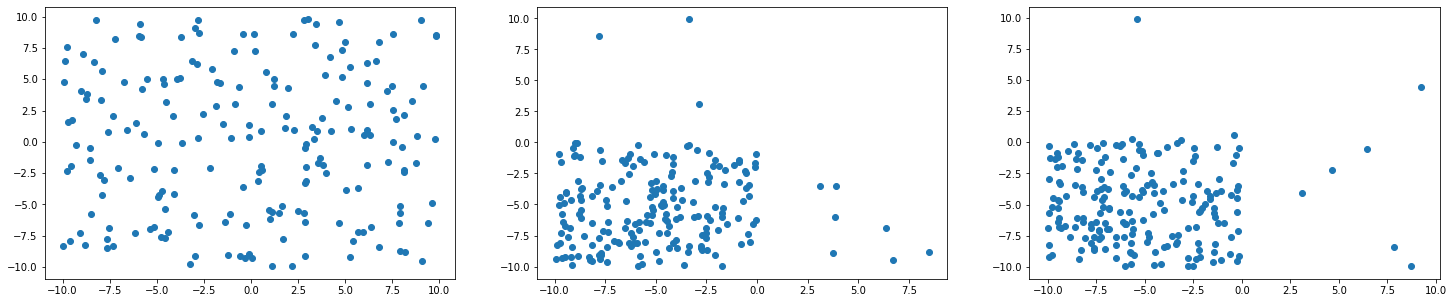

In [54]:
Display.displayParticles(firstTest_f.all_particles)

In [95]:
secondTest_g = PSO(w=0.1, c_b=100, c_g=100, n=2000000, iter=10, v_limit=100, function='g', pos_limit=100, rand_limit=10)
second_result_g = secondTest_g.PSO_iterations()

[-28.21614523 -88.64362798]
-138702483.59775218
